# Phase II: Data Curation, Exploratory Analysis and Plotting
## Stock Market Predictor

### Names: Diego Cicotoste, Ariv Ahuja, Salma Elmosallamy, Rithik Raghuraman

# Introduction 

How does the stock market work? how can you predict the stock market? what tools can you use? The stock market can seem complex and unpredictable, some would even say gambeling. One of the hardest challenges is making educated or informed decisions. The goal of this project is to tackle the uncertainty and help, stock traders make better decision on wether a stock is tradable or not. Wether to buy or sell. I would use past historical trends to make educated predictions on how the stock market would react.

### **1. Data Retrieval**  
- We used the **`yfinance` API** to retrieve daily historical **Open, High, Low, Close (OHLC)** prices and **volume data** for **S&P 500 stocks**, focusing on **Amazon (AMZN)** for the **past year**.
- The retrieved data includes essential market metrics that will serve as the foundation for feature engineering.

---

### **2. Data Cleaning and Processing**

#### **Handling Missing Data**  
- No data was missing after inspection

#### **Feature Engineering: Technical Indicators**  
We calculated several key **technical indicators** to enrich the dataset:
  - **RSI (Relative Strength Index)**: Momentum indicator over 14 days.
  - **VWAP (Volume Weighted Average Price)**: Measures the average trading price weighted by volume.
  - **EMA (Exponential Moving Average)**: Captures the smoothed trend over 20 days.
  - **ADX (Average Directional Index)**: Quantifies trend strength.

#### **More Features: Sentiment Analysis from News Articles**  
- We fetched relevant **news articles** using **NewsAPI** for the same period as the stock data.
- **VADER Sentiment Analysis** was used to calculate **compound sentiment scores** for each article.
- Sentiment scores were **aggregated by date** to align with the stock OHLC data.

#### **Data Alignment and Merging**  
- We ensured **alignment** between **OHLC data, technical indicators, log returns, and sentiment scores** using date-based indices.
- The combined DataFrame was prepared, with all relevant features available for further analysis and modeling.

---

### **3. Visualization of the Cleaned Data**

We visualized the **cleaned and processed dataset** to understand key trends and patterns:

1. **Price Trends and Indicators**:
   - **OHLC Candlestick Plots**: Show stock price movements.
   - **Overlaying VWAP and EMA**: To track trends and identify support/resistance levels.
   - **RSI and ADX Line Plots**: Visualize momentum and trend strength over time.

2. **Volume Analysis**:
   - **Normalized Volume**: Visualized to detect significant changes in trading activity.

3. **Sentiment Trends**:
   - **Sentiment Score Line Chart**: Displays how public sentiment fluctuates over time.
   - **Overlay of Sentiment with Stock Price**: To observe correlations between sentiment and price movements.


In [4]:
import yfinance as yf
import pandas as pd

def get_stock_data(symbol: str, period: str, interval: str = '1d') -> pd.DataFrame:
    """
    Retrieve stock price data for a given symbol, time period, and interval.
    Returns the stock prices as a pandas DataFrame.

    Parameters:
        symbol (str): The ticker symbol of the stock (e.g., 'AAPL').
        period (str): The period to retrieve data (e.g., '1y', '6mo', '5d').
        interval (str): The data interval (e.g., '1d', '1wk', '1mo').

    Returns:
        pd.DataFrame: DataFrame containing historical stock prices.
    """
    # Fetch data from Yahoo Finance
    stock_data = yf.download(symbol, period=period, interval=interval)

    return stock_data

In [6]:
import numpy as np

def calculate_log_returns(close: np.ndarray) -> np.ndarray:
    """
    Calculate the log returns from the close prices.
    
    Parameters:
        close (np.ndarray): Array of closing prices.
    
    Returns:
        np.ndarray: Array of log returns.
    """
    log_returns = np.log(close / close.shift(1))
    
    return log_returns


In [8]:
import pandas_ta as ta

def calculate_technical_indicators(df: pd.DataFrame) -> dict:
    """
    Calculate technical indicators and return them as NumPy arrays.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical stock prices.

    Returns:
        dict: A dictionary with technical indicators as NumPy arrays.
    """
    indicators = {}

    # Calculate RSI (Relative Strength Index)
    indicators['rsi'] = ta.rsi(df['Close'], length=20).to_numpy()

    # Calculate 20-day Exponential Moving Average (EMA)
    indicators['ema'] = ta.ema(df['Close'], length=20).to_numpy()

    # Calculate ADX (Average Directional Index)
    adx_df = ta.adx(df['High'], df['Low'], df['Close'], length=20)
    indicators['adx'] = adx_df['ADX_20'].to_numpy()

    # Calculate VWAP (Volume Weighted Average Price)
    vwap_series = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
    indicators['vwap'] = vwap_series.to_numpy()

    # Calculate normalized volume
    indicators['normalized_volume'] = (df['Volume'] / df['Volume'].rolling(window=20).mean()).to_numpy()

    return indicators

In [108]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import random
import time
from urllib.parse import quote
import undetected_chromedriver as uc

def get_seekingalpha_articles(ticker: str, start_date: datetime, end_date: datetime):
    """
    Scrapes article titles and publication dates for a given stock ticker 
    from Seeking Alpha within the specified date range.

    Parameters:
        ticker (str): Stock ticker symbol (e.g., 'AMZN').
        start_date (datetime): Start date as a datetime object.
        end_date (datetime): End date as a datetime object.

    Returns:
        pd.Series: Series of article titles.
        pd.Series: Series of article dates.
    """
    start_str = start_date.strftime('%Y-%m-%dT%H:%M:%S.000Z')
    end_str = end_date.strftime('%Y-%m-%dT%H:%M:%S.999Z')

    # URL-encode the formatted strings
    start_str = quote(start_str, safe='')
    end_str = quote(end_str, safe='')

    page_num = 1
    all_titles, all_dates = [], []


    # Set up Chrome options for headless mode
    options = uc.ChromeOptions()
    options.add_argument('--headless')
    
    # Initialize undetected-chromedriver with the configured options
    driver = uc.Chrome()

    while True:
        url = f"https://seekingalpha.com/symbol/{ticker}/news?from={start_str}&page={page_num}&to={end_str}"

        time.sleep(random.uniform(1, 3))
        driver.get(url)
    
        # Allow some time for the page to load
        time.sleep(3)

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        # Extract titles and dates
        titles = soup.find_all('a', {'data-test-id': 'post-list-item-title'})
        dates = soup.find_all('span', {'data-test-id': 'post-list-date'})

        if not titles or not dates:
            break  # Stop if no more articles are found

        for title, date in zip(titles, dates):
            title_text = title.text.strip()
            date_str = date.text.strip()

            # Handle if it is recent
            if date_str.lower().startswith('yest'):
                parsed_date = datetime.now() - timedelta(days=1)
            elif date_str.lower().startswith('toda'):
                parsed_date = datetime.now()
                
            # Handle date strings with or without a year
            elif date_str[-4:].isdigit():  # If the string contains a year
                date_format = '%a, %b %d, %Y' if "May" in date_str else '%a, %b. %d, %Y'
                parsed_date = datetime.strptime(date_str, date_format)
            else:
                date_str = f'{date_str}, {datetime.now().year}'
                date_format = '%a, %b %d, %Y' if "May" in date_str else '%a, %b. %d, %Y'
                parsed_date = datetime.strptime(date_str, date_format)

            # Append to the result lists
            all_titles.append(title_text)
            all_dates.append(parsed_date)
        
        page_num += 1

    return all_titles, all_dates

In [109]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import numpy as np
import pandas as pd
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

# Load the FinBERT model and tokenizer from Hugging Face
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

# Set up the pipeline for sentiment analysis
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None, device=0)

def analyze_sentiment(titles: list) -> np.ndarray:
    """
    Analyzes sentiment of article titles using FinBERT and returns cumulative sentiment scores.

    Parameters:
        titles (list): List of article titles.

    Returns:
        np.ndarray: Array of cumulative sentiment scores.
    """
    cumulative_scores = []

    for title in titles:
        result = nlp(title)[0]  # Get sentiment scores for the title

        # Extract individual scores
        scores = {entry['label'].lower(): entry['score'] for entry in result}
        positive = scores.get('positive', 0)
        negative = scores.get('negative', 0)

        # Calculate cumulative sentiment
        cumulative_score = positive - negative

        # Append to cumulative scores list
        cumulative_scores.append(cumulative_score)

    return np.array(cumulative_scores)


False
None


In [110]:
from datetime import datetime
import numpy as np

def merge_sentiment(
    date_list: list, 
    sent_arr: np.ndarray, 
    index_dates: np.ndarray
) -> np.ndarray:
    """
    Merges sentiment scores by date, averaging multiple scores per day. 
    If a date has no articles, it fills the sentiment with 0.

    Parameters:
        date_list (list): List of datetime objects representing article publication dates.
        sent_arr (np.ndarray): Array of sentiment scores corresponding to the article dates.
        index_dates (np.ndarray): Array of indexed dates from the DataFrame.

    Returns:
        np.ndarray: Array of average daily sentiment scores aligned with the index dates.
    """
    # Initialize an array for daily sentiment scores aligned with the index dates
    daily_sentiment = np.zeros(len(index_dates))
    
    # Create a dictionary to group sentiment scores by date
    sentiment_by_date = {}
    for date, score in zip(date_list, sent_arr):
        if date not in sentiment_by_date:
            sentiment_by_date[date] = []
        sentiment_by_date[date].append(score)
        
    # Iterate over the dates and compute the average sentiment for each
    for idx, current_date in enumerate(index_dates):
        if current_date in sentiment_by_date:
            # Calculate the average sentiment for the current date
            daily_sentiment[idx] = np.mean(sentiment_by_date[current_date])


    return daily_sentiment


In [ ]:
# Example usage
stock = 'AMZN'
period = '2y'
interval = '1d'

# Fetch stock data
stock_ohlc = get_stock_data(stock, period, interval)

# Calculate log returns
log_returns_arr = calculate_log_returns(stock_ohlc['Close'])

# Calculate technical indicators (RSI, EMA, VWAP, etc.)
technical_indicators_dict = calculate_technical_indicators(stock_ohlc)

# Add calculated fields to stock dataframe
stock_df = stock_ohlc
stock_df['log_returns'] = log_returns_arr
stock_df['rsi'] = technical_indicators_dict['rsi']
stock_df['ema'] = technical_indicators_dict['ema']
stock_df['vwap'] = technical_indicators_dict['vwap']
stock_df['adx'] = technical_indicators_dict['adx']
stock_df['normalized_volume'] = technical_indicators_dict['normalized_volume']

# Convert date to string for the article collection
first_date = stock_ohlc.index.min()
last_date = stock_ohlc.index.max()

# Get latest news articles and add sentiment scores
article_titles, dates  = get_seekingalpha_articles(stock, first_date, last_date)
sentiment_arr = analyze_sentiment(article_titles)
sentiment_aligned = merge_sentiment(dates, sentiment_arr, stock_ohlc.index.to_pydatetime())

# Add the sentiment array to the stock DataFrame
stock_df['sentiment_score'] = sentiment_aligned

# Drop Nan values from DF
stock_df = stock_df.dropna()

# Display the final dataframe
stock_df

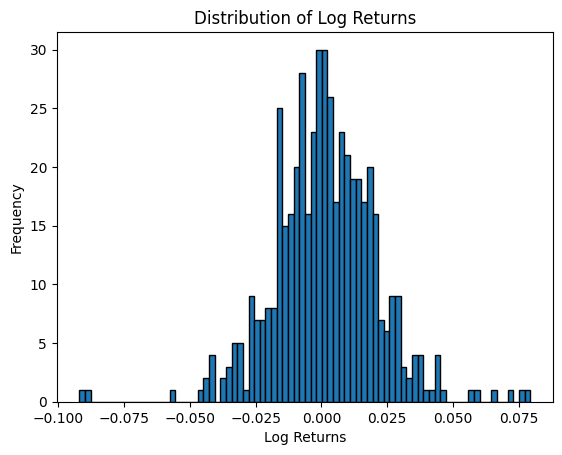

In [111]:
import matplotlib.pyplot as plt

# Plot histogram of log returns
plt.hist(log_returns_arr, bins=80, edgecolor='black')
plt.title('Distribution of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

The bimodal distribution observed in the log returns suggests volatility clustering, where the market exhibits frequent up or down movements, with fewer instances of no change. This non-linear behavior makes it challenging to use such features effectively in linear regression, as the model assumes a linear relationship between variables. The two peaks around zero highlight the market’s preference to shift rather than remain flat, reflecting non-stationary behavior. Also the data is shifted to the right slightly because stocks in general return positive returns over long time frames.

In [ ]:
# Correlations
df_corr = stock_df[["log_returns", "Volume", "rsi", "ema", "vwap", "adx", "sentiment_score"]]
correlations = df_corr.corr()
correlations

This table provides the correlations between closeing price for the day, volume of shares trades, technical indicators (like rsi, ema, vwap, adx), and sentiment score for each day the Amazon stock is traded. Based on these correlations, we can determine which variables have the strongest relationships, which gives us a better understanding of the data when analyzing. 

**Notable Relationships:**
1. **Close and EMA (exponential moving average):** The high correlation of 0.904341 suggests that EMA can be a valuable indicator in predicting the closing price of Amazon's stock. This relationship makes sense the EMA is calulated using data from historical prices. This allows investors to confidently use the EMA as part of strategies to predict price movements, identify trends, and make informed decisions on entry and exit points for their trades.  
2. **EMA and VWAP (volume weighted average price):** This relationship has a strong positive correlation of 0.907945. EMA tracks trends purely based on price, while vwap also takes volume of shares into consideration. This strong relationship suggests that price movements are well supported by trading volumes. This signals to investors good times to buy/sell a stock.    
3. **VWAP and ADX (average directional index):** There is a moderate inverse relationship between these two factors, suggested by a correlation of -0.464629. ADX is used to measure the strength of a trend. As the VWAP increases, the ADX tends to decrease, which makes sense because with a higher trading volume comes greater uncertainty and prices may be more scattered.

The correlation between technichal indicators and sentiment scores were also an area of interest for our group, however there does not appaer to be a strong relationship between any. Therefore, this tells us that the sentiment of recent news articles many not have a significant impact on stock trends. 

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=stock_df.index,
    open=stock_df['Open'],
    high=stock_df['High'],
    low=stock_df['Low'],
    close=stock_df['Close'],
    name='OHLC'
)])

# Add the EMA line
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['ema'],
    mode='lines',
    line=dict(width=1.5),
    name='EMA'
))

# Add VWAP line
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['vwap'],
    mode='lines',
    line=dict(width=1.5, dash='dash'),
    name='VWAP'
))

# Add ADX line on the secondary y-axis
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['adx'],
    mode='lines',
    line=dict(width=1.5, color='purple'),
    name='ADX',
    yaxis="y2"
))

# Add RSI line on a secondary y-axis
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['rsi'],
    mode='lines',
    line=dict(width=1.5, color='orange'),
    name='RSI',
    yaxis="y3"
))

# Update layout for readability and add secondary y-axes
fig.update_layout(
    title=f'{stock} Stock Price with Technical Indicators',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    yaxis2=dict(
        title="ADX",
        overlaying="y",
        side="right"
    ),
    yaxis3=dict(
        title="RSI",
        anchor="free",
        overlaying="y",
        side="right",
        position=0.95  
    ),
    legend=dict(x=0, y=1.15),
    template="plotly_white"
)

fig.show()

This candlestick plot shows the trend of Amazon's stock price from December 2023 all the way to the most recent date Amazon's stock was traded. The hover feature shows the date, open, close, high, and low prices of a particular day, as well as it shows the indicators we have included to help predict the graph. Additionally, based on the green and red color scheme, we can see when Amazon's stock price increased/decreased as well as the range it was traded at for the day. 

# Phase III

In [10]:
stock_df = pd.read_csv('amzn_2y.csv')

In [12]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,log_returns,rsi,ema,vwap,adx,normalized_volume,sentiment_score
0,2023-01-11,90.930000,95.260002,90.930000,95.089996,95.089996,103126200,0.056460,58.857347,87.772519,93.760000,16.446174,1.353937,-0.090275
1,2023-01-12,96.930000,97.190002,93.500000,95.269997,95.269997,85254800,0.001891,59.092719,88.486565,95.320000,16.918704,1.130404,0.113091
2,2023-01-13,94.180000,98.370003,94.120003,98.120003,98.120003,85549400,0.029476,62.653618,89.404035,96.870003,17.586948,1.122956,0.087903
3,2023-01-17,98.680000,98.889999,95.730003,96.050003,96.050003,72755000,-0.021322,58.744092,90.036984,96.890002,18.294529,0.962623,-0.019294
4,2023-01-18,97.250000,99.320000,95.379997,95.459999,95.459999,79570400,-0.006162,57.664529,90.553462,96.719999,19.021528,1.101301,-0.118302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,2024-11-06,200.009995,207.550003,199.139999,207.089996,207.089996,72292200,0.037339,66.376340,191.900874,204.593333,12.820632,1.930385,0.491510
459,2024-11-07,207.440002,212.250000,207.190002,210.050003,210.050003,52878400,0.014192,68.067186,193.629362,209.830002,14.019819,1.366215,0.735861
460,2024-11-08,209.720001,209.960007,207.440002,208.179993,208.179993,36075800,-0.008943,65.864570,195.015136,208.526667,15.159047,0.919820,0.625888
461,2024-11-11,208.500000,209.649994,205.589996,206.839996,206.839996,35405100,-0.006458,64.295235,196.141314,207.359996,16.010175,0.888235,0.000000


In [14]:
from sklearn.preprocessing import StandardScaler

# Set up the features (X) and target (y)
X_pd = stock_df[['rsi', 'ema', 'vwap', 'adx', 'normalized_volume', 'sentiment_score']]
y_pd = np.where(stock_df[['log_returns']] >= 0, 1, -1)

X = stock_df[['rsi', 'ema', 'vwap', 'adx', 'normalized_volume', 'sentiment_score']].to_numpy()
y = np.where(stock_df[['log_returns']].to_numpy() >= 0, 1, -1)

# Get the number of samples
n = stock_df.shape[0]

# Calculate the indices for the splits
train_end = int(0.65 * n)  # 65% for training
cv_end = int(0.80 * n)     # Next 15% for CV

# Split the data
X_train = X[:train_end]
X_cv = X[train_end:cv_end]
X_test = X[cv_end:]

y_train = y[:train_end]
y_cv = y[train_end:cv_end]
y_test = y[cv_end:]

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

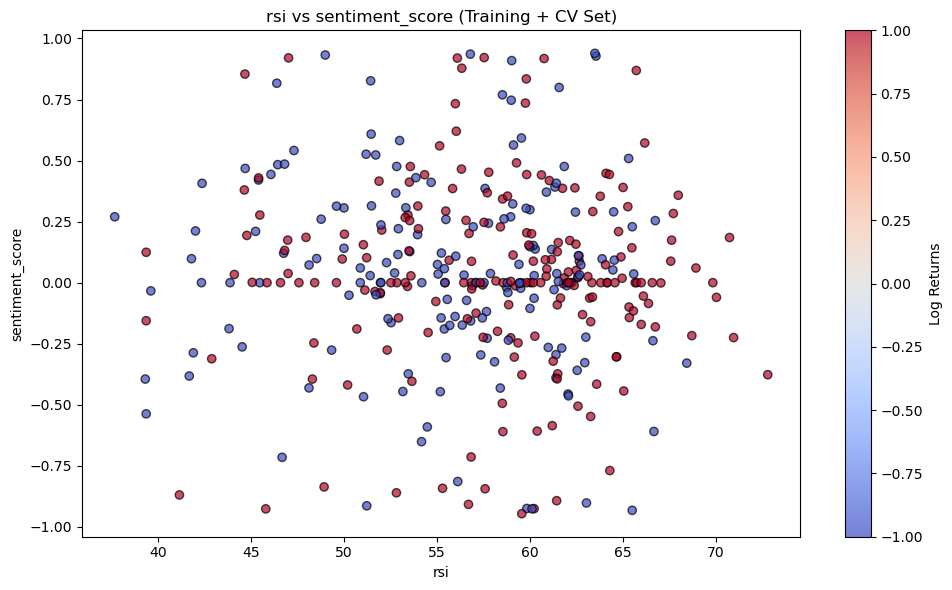

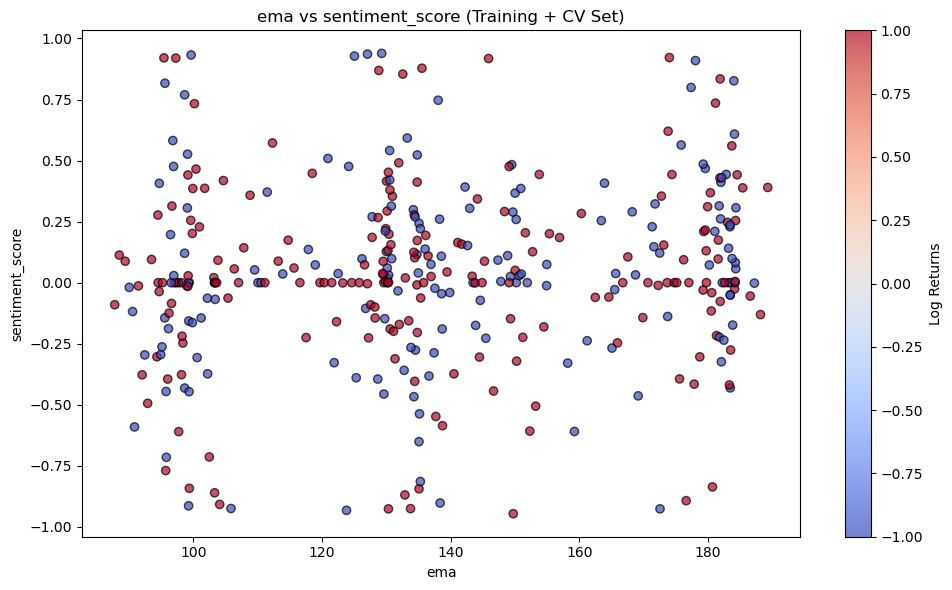

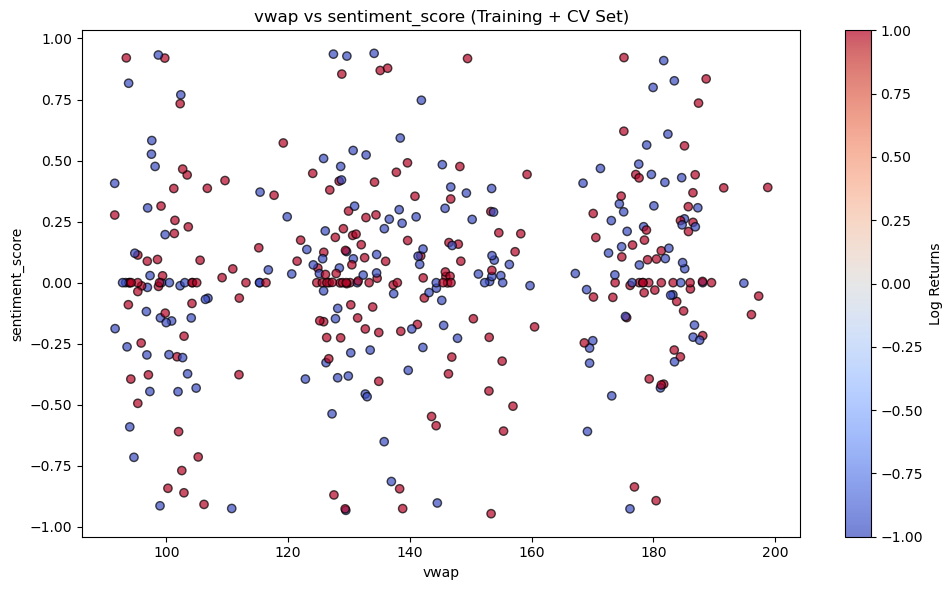

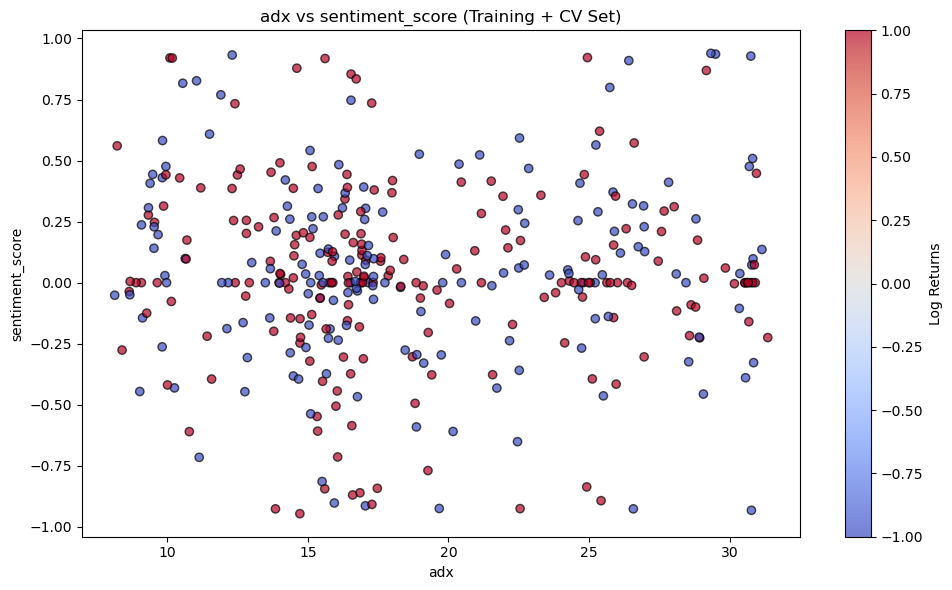

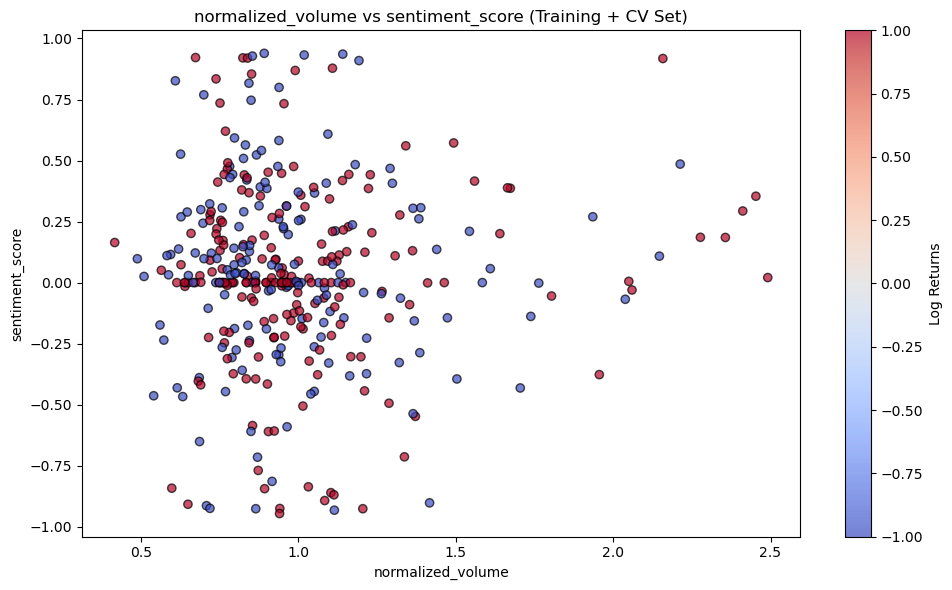

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine training and cross-validation sets
X_combined = X_pd[:cv_end]
y_combined = y_pd[:cv_end]

# List of features to combine with sentiment_score
features = ['rsi', 'ema', 'vwap', 'adx', 'normalized_volume']
sentiment_feature = 'sentiment_score'
target = 'log_returns'  # Target variable

# Plot combined scatter plots
def plot_combined_scatter(X, y, features, sentiment_feature):
    for feature in features:
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for combined data
        scatter = plt.scatter(
            X[feature],
            X[sentiment_feature],
            c=y.flatten(),  # Ensure y is properly flattened for coloring
            cmap='coolwarm',
            alpha=0.7,
            edgecolors='k'
        )
        
        # Set labels and title
        plt.title(f'{feature} vs {sentiment_feature} (Training + CV Set)')
        plt.xlabel(feature)
        plt.ylabel(sentiment_feature)

        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Log Returns')

        plt.tight_layout()
        plt.show()

# Call the function to create scatter plots
plot_combined_scatter(X_combined, y_combined, features, sentiment_feature)

In [18]:
from collections import Counter

# Assuming y is a numpy array with values -1 and 1
counts = Counter(y_combined.flatten())

# Extract the number of 1's and -1's
num_ones = counts[1]
num_neg_ones = counts[-1]

print(f'Niave Guess Accuracy: {max(num_ones, num_neg_ones)/(num_ones+num_neg_ones)}')

Niave Guess Accuracy: 0.5459459459459459


After reviewing these plots I noticed that the rsi seemed like a pretty good feature to use as when it was higher the next day seemed to be more likely to be a win. This would imply that as a stock goes up it is more likely to go up in the future. The sentiment score does not seem as good as hypothesized even though it is an exteranl source that is not based on the underlying price.

In [21]:
def linear_perceptron(X, y, w, alpha = 1, max_iter = None):
    """
    Implements the perceptron algorithm to update the weight vector `w` based on the given data.

    Parameters:
    X (numpy.ndarray): A 2D array where rows are data points and columns are features (including bias column of 1s).
    y (numpy.ndarray): A 1D array of labels (-1 or 1) corresponding to each row in `X`.
    w (numpy.ndarray): Initial weight vector with the same number of dimensions as the columns of `X`.
    alpha (float): Learning rate, with a default value of 1.
    max_iter (int or None): Maximum number of iterations. If `None`, the algorithm will run until convergence.

    Returns:
    numpy.ndarray: The final weight vector `w` after applying the perceptron algorithm.
    """
    # Don't forget your docstring!

    # I will set up the key parameters of the function and then the while loop
    # you are responsible for the rest
    runalg = True
    i = 0
    iter = 0

    while runalg:

        # for the current i, make the prediction
        y_hat = 1 if (np.dot(X[i], w)) > 0 else -1
        # check if it is correct
        if y_hat != y[i]:
            # if not, update w
            w = w + alpha * y[i] * X[i]
        # add one to i
        i += 1
        # if you've just updated the last i (the last observation in the data), add one to iter
        if i == X.shape[0]:
            i = 0
            iter += 1
        # if you've set a max_iter, and if you've REACHED the max_iter, set runalg = False, print w and iter, and break
        if max_iter and iter >= max_iter:
            runalg = False
            print(f"Final weights: {w}, Iterations: {iter}")
            break
            
    return w

In [23]:
import numpy as np

# Add a bias term (column of 1s) to the features
X_train_bias = np.hstack((X_train_scaled, np.ones((X_train_scaled.shape[0], 1))))
X_cv_bias = np.hstack((X_cv_scaled, np.ones((X_cv_scaled.shape[0], 1))))

# Ensure labels are in {-1, 1}
y_train_adjusted = np.where(y_train > 0, 1, -1)
y_cv_adjusted = np.where(y_cv > 0, 1, -1)

# Initialize weight vector (same length as number of columns in X_train_bias)
w_initial = np.zeros(X_train_bias.shape[1])

# Train the perceptron
w_final = linear_perceptron(X_train_bias, y_train_adjusted, w_initial, alpha=1, max_iter=1000)

# Make predictions on the training set
y_train_pred = np.sign(np.dot(X_train_bias, w_final))

# Make predictions on the cross-validation set
y_cv_pred = np.sign(np.dot(X_cv_bias, w_final))

# Compute training and cross-validation accuracies
train_accuracy = np.mean(y_train_pred == y_train_adjusted)
cv_accuracy = np.mean(y_cv_pred == y_cv_adjusted)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Cross-Validation Accuracy: {cv_accuracy:.2f}")

Final weights: [ 10.16807397  48.86571768 -46.7050491   -4.78050379   1.01578797
   2.16782254   2.        ], Iterations: 1000
Training Accuracy: 0.51
Cross-Validation Accuracy: 0.54


As seen above the Linear Perceptron model was able to reach 51% accuracy, which is similar to guessing. This shows that this model struggles to learn patterns. When we tried the Cross-Validation we got an accurracy of 54% which is sligtly better than Linear Perceptron. Additionally, the algorithm reached the maximum number of iterations (1000) without converging, implying that the dataset is likely not linearly separable. In such cases, the Perceptron cannot find a decision boundary that perfectly separates the classes.

Due to the performance being really poorly, that suggests that we should not relly it's model. The final weight vector reflects the learned coefficients for each feature and the bias term, but these weights fail to establish a reliable decision boundary. The underperformance is likely due to non-linear relationships in the data, class imbalance, and a lack of feature interactions, which the Perceptron cannot adequately handle. The inability of the model to outperform a naive guess highlights its limitations in this context.

In [26]:
import warnings
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=4, class_weight='balanced', random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_scaled, y_train)

# Predict on the training set
y_train_pred = rf_classifier.predict(X_train_scaled)

# Predict on the cross-validation set
y_cv_pred = rf_classifier.predict(X_cv_scaled)

# Evaluate the model's performance on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Evaluate the model's performance on the cross-validation set
cv_accuracy = accuracy_score(y_cv, y_cv_pred)
print(f"Cross-validation Accuracy: {cv_accuracy:.2f}")

# Print detailed classification metrics for training set
print("Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred))

# Print detailed classification metrics for cross-validation set
print("Classification Report (Cross-Validation):")
print(classification_report(y_cv, y_cv_pred))

Training Accuracy: 0.90
Cross-validation Accuracy: 0.61
Classification Report (Training Set):
              precision    recall  f1-score   support

          -1       0.85      0.95      0.90       136
           1       0.95      0.86      0.90       164

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300

Classification Report (Cross-Validation):
              precision    recall  f1-score   support

          -1       0.73      0.25      0.37        32
           1       0.59      0.92      0.72        38

    accuracy                           0.61        70
   macro avg       0.66      0.59      0.55        70
weighted avg       0.65      0.61      0.56        70



The Random Forest model with 4 estimators shows a high train accuracy of 90%, meaning that the model performed well on the training data. In the case of stock-down days (-1), it has a precision of 0.85 and a recall of 0.95-that is, it can identify 95% of the actual stock-down days correctly with a very high confidence level in the prediction for this class. For the days of stock-up, for example, its precision amounts to 0.95 while its recall equates to 0.86, representing that the model can correctly identify 86% of real stock-up days with quite strong confidence. These finally yield balanced F1-scores for both classes (0.90 each) and assure that the model has duly learned from this training set.

On the cross-validation set, the accuracy drops to 61%, indicating that this model generalizes poorly to new, unseen data. For class stock-down days (-1), the precision is 0.73, which means there is reasonable confidence in the model when it predicts this class, but the recall drops to 0.25, meaning only 25% of actual stock-down days are identified by the model. This results in a low F1-score for the -1 class, amounting to 0.37. In contrast, the model performs better for stock-up days (1), achieving a precision of 0.59 and a recall of 0.92, correctly identifying 92% of stock-up days while maintaining moderate confidence in its predictions. The F1-score for the 1 class is 0.72, reflecting better performance compared to the -1 class.

Overall, the model is performing very well on the training set but is overfitting, as can be seen by the difference in performance between the training and cross-validation sets. The cross-validation results indicate a bias towards predicting stock-up days (1) with higher recall for this class and lower recall for stock-down days (-1). In the pursuit of better generalization and balancing the predictions, increasing the number of estimators, tuning hyperparameters with regard to max_depth and min_samples_split, or further addressing class imbalance through techniques such as oversampling the minority class or further adjustments of class_weight could help. This would enable the model to balance its predictions as well as generalize effectively to unseen data.

### Ethical Concerns

When applying models like the Linear Perceptron or Random Forest to stock market predictions, a significant ethical concern is data bias and fairness. These models are trained on historical stock data, which may inadvertently reflect systemic biases, such as favoring certain sectors, companies, or periods of economic growth while neglecting others. For example, a Random Forest trained on data predominantly from a bullish market might predict upward trends more often, disadvantaging strategies that rely on balanced or bearish predictions. This raises fairness concerns, as the model's outputs might reinforce existing inequities in the market or mislead less informed traders.

Another critical issue is transparency and accountability, especially with more complex models like Random Forests. While the Linear Perceptron provides clear decision boundaries, the Random Forest operates as a "black box," making it difficult for users to understand how predictions are made. In stock trading, this lack of interpretability can lead to distrust in automated systems, especially when financial losses occur. Traders relying on these models may not fully understand the risks, potentially leading to over-reliance on predictions without critical oversight.

Finally, the issue of accessibility and inequality is particularly relevant. Developing and deploying these models requires access to large datasets, computational resources, and domain expertise—resources often concentrated within institutional investors or well-funded individuals. Smaller investors are typically excluded from leveraging such tools, exacerbating existing wealth disparities. Without efforts to democratize these technologies, such as providing affordable tools or educational resources, these predictive models could widen the gap between institutional and retail traders, creating a less equitable financial landscape.

Training Accuracy: 0.66
Testing Accuracy: 0.57


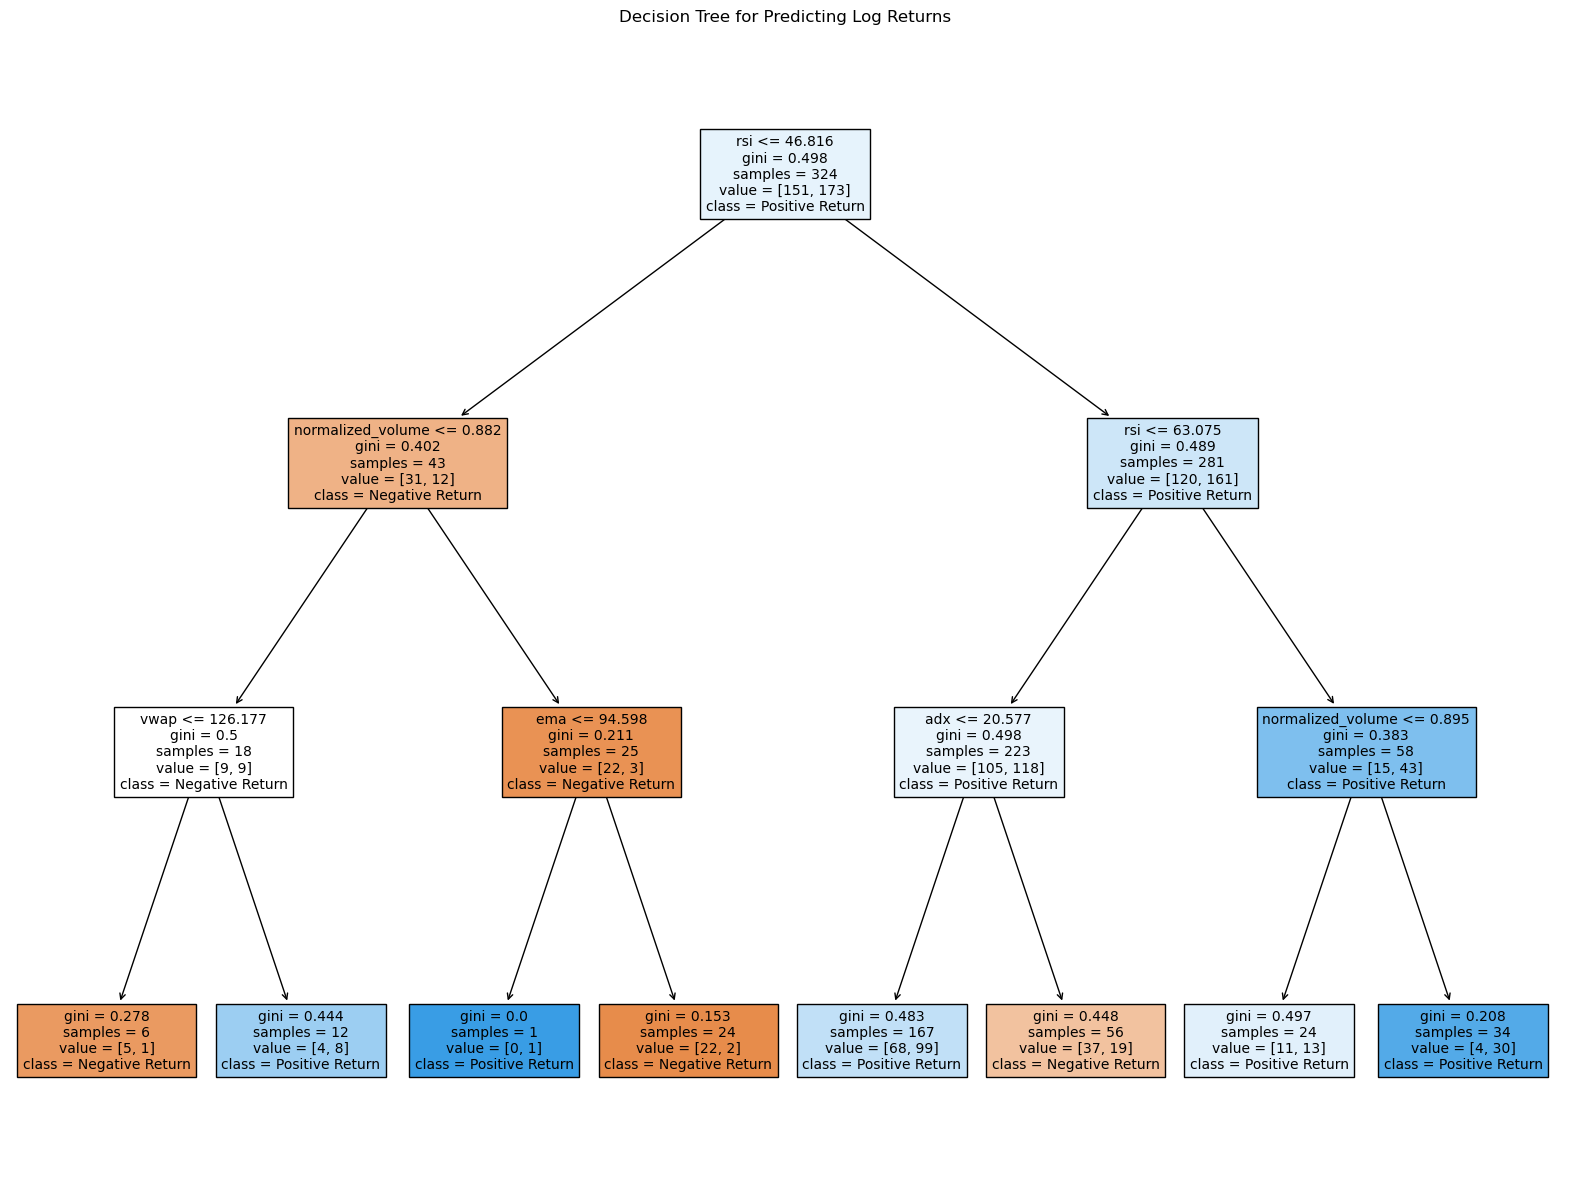

In [45]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Convert `log_returns` to a binary classification target: 1 for positive, 0 for negative
stock_df['log_returns_binary'] = (stock_df['log_returns'] > 0).astype(int)

# Select features and target
features = ['rsi', 'ema', 'vwap', 'adx', 'normalized_volume', 'sentiment_score']
X = stock_df[features]
y = stock_df['log_returns_binary']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Visualize the decision tree
plt.figure(figsize=(20, 15))
plot_tree(
    clf, 
    feature_names=features, 
    class_names=['Negative Return', 'Positive Return'], 
    filled=True, 
    fontsize=10
)
plt.title("Decision Tree for Predicting Log Returns")
plt.show()